This is needed to reload modules without restarting the kernel

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This is needed to add eda_tools from the directories above

In [10]:
import os
os.sys.path.append('../../')

# Reweighing but with uniform noise instead

Let's see if we can perform the reweighting but with uniform noise instead

In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.1.0'

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import  BatchNormalization


In [5]:
f = uproot.open('/mnt/storage/lborgna/NNT/data17_with_weights.root')

In [6]:
f.keys()

[b'validation;1',
 b'control;1',
 b'sig;1',
 b'fullmassplane;1',
 b'NN_norm_bstrap_med_17;1',
 b'NN_norm_bstrap_IQR_17;1',
 b'NN_norm_bstrap_perc_25_17;1',
 b'NN_norm_bstrap_perc_75_17;1',
 b'NN_norm_VRderiv_bstrap_med_17;1',
 b'NN_norm_VRderiv_bstrap_IQR_17;1',
 b'NN_norm_VRderiv_bstrap_perc_25_17;1',
 b'NN_norm_VRderiv_bstrap_perc_75_17;1']

In [7]:
df_cr = f['control'].pandas.df()

In [11]:
from eda_tools.NN_RW import nominal, louppe_loss, log_inputs, create_labels, NN

Using TensorFlow backend.


In [12]:
features_to_rw = nominal()

In [15]:
features_to_rw

{'rw_cols_to_log': ['pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'X_wt'],
 'rw_cols_log': ['pT_2_log',
  'pT_4_log',
  'eta_i',
  'dRjj_1_log',
  'dRjj_2_log',
  'njets',
  'pt_hh_log',
  'X_wt_log',
  'dR_hh',
  'dPhi_h1',
  'dPhi_h2']}

In [14]:
from eda_tools.utilities import calculatedPhi, calculatedRhh

In [23]:
calculatedPhi(df_cr)
calculatedRhh(df_cr)

In [24]:
log_inputs(df_cr, to_log=features_to_rw['rw_cols_to_log'])

pT_2 already in dataset, skipping
pT_4 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
X_wt already in dataset, skipping


In [25]:
train_size = df_cr.shape[0]

In [26]:
target

NameError: name 'target' is not defined

In [27]:
original = df_cr.loc[df_cr['ntag'] == 2, features_to_rw['rw_cols_log']]

In [29]:
target.shape

(29775, 11)

In [33]:
df_cr.loc[df_cr['ntag']>=4, features_to_rw['rw_cols_log']].describe([0.01,0.99])

pT_2_log      pT_4_log         eta_i    dRjj_1_log    dRjj_2_log  \
count  29775.000000  29775.000000  29775.000000  29775.000000  29775.000000   
mean       4.510019      3.973177      0.853275     -0.191922      0.406662   
std        0.343250      0.209439      0.375452      0.353440      0.431502   
min        3.728542      3.688882      0.074607     -1.507366     -0.860933   
1%         3.927532      3.694022      0.221733     -0.853682     -0.569696   
50%        4.443305      3.935347      0.788212     -0.208429      0.422972   
99%        5.497811      4.625592      1.846604      0.587417      1.205988   
max        6.435066      5.327324      2.301720      0.862796      1.483433   

              njets     pt_hh_log      X_wt_log         dR_hh       dPhi_h1  \
count  29775.000000  29775.000000  29775.000000  29775.000000  29775.000000   
mean       4.798825      4.105711      1.002879      2.564581      1.480498   
std        0.901455      0.905297      0.370155      0.751084      0.883633   
min        4.000000     -1.454024      0.405537      0.013529      0.000200   
1%         4.000000      1.724182      0.419499      0.348131      0.035547   
50%        5.000000      4.158133      0.963682      2.864845      1.365301   
99%        8.000000      5.862105      1.862802      3.402697      3.102395   
max       11.000000      6.772427      2.174903      3.476465      3.141501   

            dPhi_h2  
count  29775.000000  
mean       1.510695  
std        0.905701  
min        0.000029  
1%         0.033221  
50%        1.440011  
99%        3.102972  
max        3.141421

In [28]:
target = df_cr.loc[df_cr['ntag']>=4, features_to_rw['rw_cols_log']]

In [22]:
X_all = pd.concat((original, target), ignore_index=True).values
Y_all = create_labels(original, target)

In [23]:
Y_all = Y_all.astype('float32')

In [24]:
scaler = StandardScaler()

In [25]:
X_train = scaler.fit_transform(X_all)
Y_train = Y_all.copy()

In [26]:
idx = np.random.permutation(X_train.shape[0])

In [27]:
X_train = X_train[idx]
Y_train = Y_train[idx]

In [28]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=X_train.shape[1]),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
    ]
)

In [29]:
import tensorflow.keras.backend as K

In [30]:
def louppe_loss_tf2(y_true, y_pred):
    return (y_true * (K.sqrt(K.exp(y_pred))) + (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred))))

In [31]:
model.compile(loss=louppe_loss_tf2, metrics = ['accuracy'], optimizer='adam')

In [32]:
history = model.fit(X_train, Y_train,
                    callbacks = [
                            EarlyStopping(monitor='val_loss', patience=10, verbose=True),
                            ModelCheckpoint('model.h5', monitor='val_loss', verbose=True, save_best_only=True) ],
                            epochs=500,
                            validation_split = 0.4,
                            batch_size=8192,
                   )

Train on 1060994 samples, validate on 707330 samples
Epoch 1/500
 983040/1060994 [==========================>...] - ETA: 0s - loss: 0.3201 - accuracy: 0.0168
Epoch 00001: val_loss improved from inf to 0.24505, saving model to model.h5
1060994/1060994 [==============================] - 3s 3us/sample - loss: 0.3142 - accuracy: 0.0168 - val_loss: 0.2451 - val_accuracy: 0.0169
Epoch 2/500
1024000/1060994 [===========================>..] - ETA: 0s - loss: 0.2410 - accuracy: 0.0168
Epoch 00002: val_loss improved from 0.24505 to 0.23834, saving model to model.h5
1060994/1060994 [==============================] - 1s 1us/sample - loss: 0.2409 - accuracy: 0.0168 - val_loss: 0.2383 - val_accuracy: 0.0169
Epoch 3/500
1032192/1060994 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.0168
Epoch 00003: val_loss improved from 0.23834 to 0.23580, saving model to model.h5
1060994/1060994 [==============================] - 1s 1us/sample - loss: 0.2365 - accuracy: 0.0168 - val_loss: 

In [33]:
model.load_weights('model.h5')

In [34]:
Y_train==0

array([False, False, False, ..., False, False, False])

In [42]:
X_val = X_train[-5000:]

In [43]:
X_val.shape

(5000, 11)

In [44]:
e = shap.DeepExplainer(model, X_val)

In [45]:
X_train[39]

array([ 1.98374949, -1.15840074, -1.18299126,  0.83849613,  0.39735793,
       -0.50991007,  0.42417886, -0.38823591,  0.17218789, -0.37609768,
        0.37303768])

In [46]:
shap_values = e.shap_values(X_val)

In [47]:
X_train.shape

(1768324, 11)

In [48]:
len(features_to_rw['rw_cols_log'])

11

In [49]:
help(shap.summary_plot)

Help on function summary_legacy in module shap.plots._beeswarm:

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f492bd05080>, auto_size_plot=None, use_log_scale=False)
    Create a SHAP beeswarm plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names :

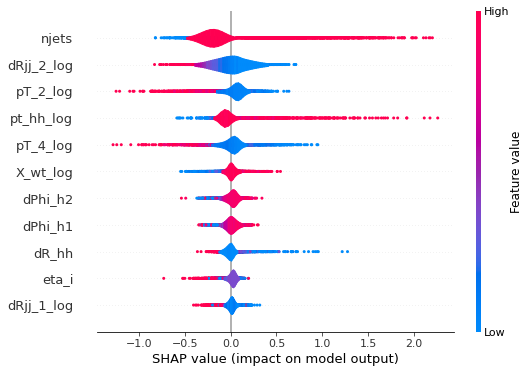

In [50]:
shap.summary_plot(
    shap_values[0], X_val,
    feature_names=features_to_rw["rw_cols_log"], plot_type="violin"
)

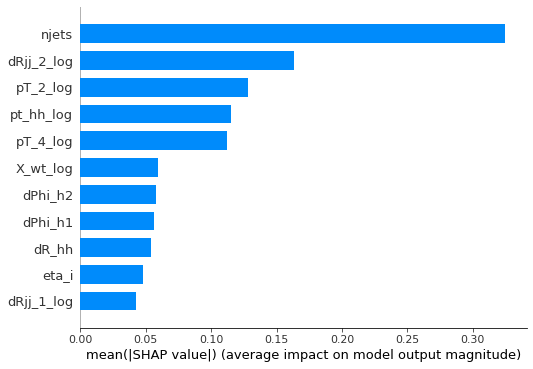

In [51]:
shap.summary_plot(
    shap_values[0], X_val,
    feature_names=features_to_rw["rw_cols_log"], plot_type="bar"
)

In [73]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [76]:
plt.gcf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.

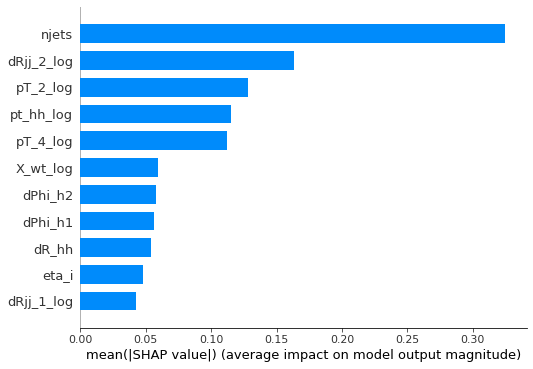

In [80]:
f = shap.summary_plot(
    shap_values[0],
    X_val,
    feature_names=features_to_rw["rw_cols_log"],
    plot_type="bar",
    show=False,
)

In [81]:
plt.savefig("test.pdf")

<Figure size 432x288 with 0 Axes>

![](test.png)

is the model fucked?

In [122]:
df_cr_2b = df_cr.loc[df_cr['ntag']==2]

In [123]:
pred = model.predict(scaler.transform(df_cr_2b[features_to_rw['rw_cols_log']].values), batch_size=8192)

In [124]:
df_cr_2b['NN_weight'] = np.exp(pred)[:,0]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [125]:
df_cr

run_number  event_number  mc_sf  ntag  njets  kinematic_region  \
entry                                                                     
0            326439      14652024    1.0     2      6                 2   
1            326439      11602927    1.0     2      4                 2   
2            326834    1087618060    1.0     2      5                 2   
3            326834    1697395418    1.0     2      5                 2   
4            326834    1697390982    1.0     2      5                 2   
...             ...           ...    ...   ...    ...               ...   
1790768      339957    4051406214    1.0     2      4                 2   
1790769      339957    4050716165    1.0     2      4                 2   
1790770      339957    4050478885    1.0     2      4                 2   
1790771      339957    4050925278    1.0     2      5                 2   
1790772      339957    4050762983    1.0     2      4                 2   

           m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
entry                                                              ...   
0        125.869003  380.672729         0.999066         0.008059  ...   
1         36.704128  152.690079         0.505523         0.501644  ...   
2         69.662872  237.000824         0.127664         0.063937  ...   
3        137.971207  539.372803         0.999432         0.002289  ...   
4        128.280594  471.250092         0.999404         0.003416  ...   
...             ...         ...              ...              ...  ...   
1790768  106.480461  282.510315         0.987182         0.073778  ...   
1790769   34.068737  263.774963         0.338067         0.174075  ...   
1790770  113.185013  302.098572         0.989712         0.012861  ...   
1790771  134.292450  257.755249         0.882444         0.054471  ...   
1790772  120.021294  254.511124         0.803703         0.435764  ...   

         NN_d24_weight_VRderiv_bstrap_IQR_17   dPhi_h1   dPhi_h2     dR_hh  \
entry                                                                        
0                                   0.006992  0.712290  1.113665  3.269802   
1                                   0.003047  2.735859  2.873533  2.859212   
2                                   0.005574  1.211610  1.496300  3.261541   
3                                   0.003287  0.657044  0.937919  3.052898   
4                                   0.002947  0.743185  0.861584  2.975830   
...                                      ...       ...       ...       ...   
1790768                             0.002155  1.376502  1.066973  2.992440   
1790769                             0.002147  2.019342  1.258126  2.900200   
1790770                             0.001740  0.959357  0.397834  2.971416   
1790771                             0.010816  1.011240  0.786170  2.885606   
1790772                             0.002877  1.508848  1.141601  3.208356   

         pT_2_log  pT_4_log  dRjj_1_log  dRjj_2_log  pt_hh_log  X_wt_log  
entry                                                                     
0        4.922156  4.094102    0.077623    0.150979   3.901757  1.254881  
1        4.068959  3.933927   -0.552564    0.324374   3.571677  0.877563  
2        4.276298  3.850584    0.301334    1.091012   3.377382  0.464966  
3        5.381969  4.357126   -0.239998    0.062671   4.999299  1.146898  
4        5.260033  4.285115   -0.217042   -0.146484   4.207677  1.200682  
...           ...       ...         ...         ...        ...       ...  
1790768  4.833177  4.216176    0.120126    0.466270   3.923227  1.564158  
1790769  4.190639  3.841277   -0.682192    1.167135   4.342710  0.960172  
1790770  4.620880  4.014882    0.299267    0.343568   4.373713  1.459312  
1790771  4.403122  3.976500    0.250080    0.698023   4.513000  1.284013  
1790772  4.497886  4.019805    0.421566    0.676250   1.876268  1.342464  

[1790773 rows x 84 columns]

In [126]:
df_cr_2b

run_number  event_number  mc_sf  ntag  njets  kinematic_region  \
entry                                                                     
0            326439      14652024    1.0     2      6                 2   
1            326439      11602927    1.0     2      4                 2   
2            326834    1087618060    1.0     2      5                 2   
3            326834    1697395418    1.0     2      5                 2   
4            326834    1697390982    1.0     2      5                 2   
...             ...           ...    ...   ...    ...               ...   
1790768      339957    4051406214    1.0     2      4                 2   
1790769      339957    4050716165    1.0     2      4                 2   
1790770      339957    4050478885    1.0     2      4                 2   
1790771      339957    4050925278    1.0     2      5                 2   
1790772      339957    4050762983    1.0     2      4                 2   

           m_min_dj    m_max_dj  pairing_score_1  pairing_score_2  ...  \
entry                                                              ...   
0        125.869003  380.672729         0.999066         0.008059  ...   
1         36.704128  152.690079         0.505523         0.501644  ...   
2         69.662872  237.000824         0.127664         0.063937  ...   
3        137.971207  539.372803         0.999432         0.002289  ...   
4        128.280594  471.250092         0.999404         0.003416  ...   
...             ...         ...              ...              ...  ...   
1790768  106.480461  282.510315         0.987182         0.073778  ...   
1790769   34.068737  263.774963         0.338067         0.174075  ...   
1790770  113.185013  302.098572         0.989712         0.012861  ...   
1790771  134.292450  257.755249         0.882444         0.054471  ...   
1790772  120.021294  254.511124         0.803703         0.435764  ...   

          dPhi_h1   dPhi_h2     dR_hh  pT_2_log  pT_4_log  dRjj_1_log  \
entry                                                                   
0        0.712290  1.113665  3.269802  4.922156  4.094102    0.077623   
1        2.735859  2.873533  2.859212  4.068959  3.933927   -0.552564   
2        1.211610  1.496300  3.261541  4.276298  3.850584    0.301334   
3        0.657044  0.937919  3.052898  5.381969  4.357126   -0.239998   
4        0.743185  0.861584  2.975830  5.260033  4.285115   -0.217042   
...           ...       ...       ...       ...       ...         ...   
1790768  1.376502  1.066973  2.992440  4.833177  4.216176    0.120126   
1790769  2.019342  1.258126  2.900200  4.190639  3.841277   -0.682192   
1790770  0.959357  0.397834  2.971416  4.620880  4.014882    0.299267   
1790771  1.011240  0.786170  2.885606  4.403122  3.976500    0.250080   
1790772  1.508848  1.141601  3.208356  4.497886  4.019805    0.421566   

         dRjj_2_log  pt_hh_log  X_wt_log  NN_weight  
entry                                                
0          0.150979   3.901757  1.254881   0.021189  
1          0.324374   3.571677  0.877563   0.016169  
2          1.091012   3.377382  0.464966   0.015380  
3          0.062671   4.999299  1.146898   0.008109  
4         -0.146484   4.207677  1.200682   0.006014  
...             ...        ...       ...        ...  
1790768    0.466270   3.923227  1.564158   0.007021  
1790769    1.167135   4.342710  0.960172   0.007283  
1790770    0.343568   4.373713  1.459312   0.009779  
1790771    0.698023   4.513000  1.284013   0.034945  
1790772    0.676250   1.876268  1.342464   0.009625  

[1738549 rows x 85 columns]

In [127]:
df_cr = df_cr.merge(
    df_cr_2b[["event_number", "run_number", "NN_weight"]],
    how="left",
    on=["event_number", "run_number"],
)

In [129]:
df_cr['NN_weight'].isna().value_counts()

False    1738549
True       52224
Name: NN_weight, dtype: int64

In [130]:
df_cr.fillna({'NN_weight':1}, inplace = True)

In [133]:
from eda_tools.utilities import getNorm

In [136]:
help(getNorm)

Help on function getNorm in module eda_tools.utilities:

getNorm(df, k, verbose=False, weight_column=None)
    Return the 2b -> 4b normalization in a specified kinematic region
    
    Inputs:
    - df: pandas df for data events
    - k: The kinematic region to calculate this normalization in
         * 2: SB
         * 1: CR
    - verbose: Prints out the value of 4b, 2b and ratio. Return type includes 4b and 2b values



In [138]:
muQCD = getNorm(df_cr, k=2, weight_column='NN_weight')

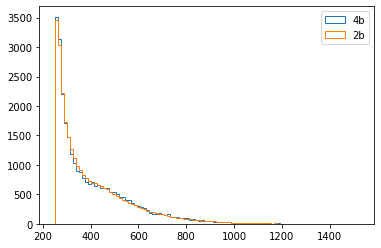

In [141]:
_,be,_ =plt.hist(df_cr.loc[df_cr.ntag>=4,'m_hh_cor'].values,
                bins = 100,
                histtype='step',
                label = '4b'
               )
_,_,_ = plt.hist(df_cr.loc[df_cr.ntag==2,'m_hh_cor'].values,
                bins = be, 
                histtype='step',
                label = '2b',
                weights=muQCD * df_cr.loc[df_cr.ntag==2,'NN_weight'].values
                )
plt.legend()

model seems to work just fine.

# Debug Ideas

save model summary to file

In [87]:
def myprint(s):
    with open('modelsummary.txt','w+') as f:
        print(s, file=f)
        
model.summary(print_fn=myprint)

In [84]:
model.summary(print_fn=myprint)

In [88]:
!cat modelsummary.txt

_________________________________________________________________


In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,751
Trainable params: 5,751
Non-trainable params: 0
_________________________________________________________________


In [89]:
from contextlib import redirect_stdout

with open('modelsummary2.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [90]:
!cat modelsummary2.txt

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,751
Trainable params: 5,751
Non-trainable params: 0
_________________________________________________________________


In [91]:
with open('modelsummary3.txt', 'w') as f:

    model.summary(print_fn=lambda x: f.write(x + '\n'))

In [92]:
!cat modelsummary3.txt

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,751
Trainable params: 5,751
Non-trainable params: 0
_________________________________________________________________


In [95]:
len(features_to_rw["rw_cols_log"])

11

### Debug KR

In [35]:
def xhh(
    m_h1: np.array, m_h2: np.array, m_h1_center: float, m_h2_center: float
) -> np.array:

    return np.sqrt(
        ((m_h1 - m_h1_center) / (0.1 * m_h1)) ** 2
        + ((m_h2 - m_h2_center) / (0.1 * m_h2)) ** 2
    )


def vrhh(
    m_h1: np.array, m_h2: np.array, m_h1_center: float, m_h2_center: float
) -> np.array:
    return np.sqrt((m_h1 - 1.03 * m_h1_center) ** 2 + (m_h2 - 1.03 * m_h2_center) ** 2)


def crhh(
    m_h1: np.array, m_h2: np.array, m_h1_center: float, m_h2_center: float
) -> np.array:
    return np.sqrt((m_h1 - 1.05 * m_h1_center) ** 2 + (m_h2 - 1.05 * m_h2_center) ** 2)


def kinematic_regions(
    df: pd.DataFrame,
    m_h1_center: float = 120.0,
    m_h2_center: float = 110.0,
    sr_cut: float = 1.6,
    vr_cut: float = 30.0,
    cr_cut: float = 45.0,
) -> pd.DataFrame:

    m_h1 = df["m_h1"].values
    m_h2 = df["m_h2"].values

    xhh_mask = xhh(m_h1, m_h2, m_h1_center, m_h2_center) < sr_cut

    vrhh_mask = vrhh(m_h1, m_h2, m_h1_center, m_h2_center) < vr_cut

    crhh_mask = crhh(m_h1, m_h2, m_h1_center, m_h2_center) < cr_cut

    df["kinematic_region"] = 3  # Everywhere else

    # Signal Region
    df.loc[xhh_mask, "kinematic_region"] = 0

    # Validation Region
    df.loc[~xhh_mask & vrhh_mask, "kinematic_region"] = 1

    # Control Region
    df.loc[~xhh_mask & ~vrhh_mask & crhh_mask, "kinematic_region"] = 2

    return df

In [36]:
df_cr['kinematic_region_old'] = df_cr['kinematic_region']

In [68]:
df_cr = kinematic_regions(df_cr, 120, 110, 1.6, 30, 45)

In [69]:
df_cr['kinematic_region_old'].value_counts()

2    1790773
Name: kinematic_region_old, dtype: int64

In [70]:
df_cr['kinematic_region'].value_counts()

2    1790771
1          2
Name: kinematic_region, dtype: int64

In [41]:
m_h1 = df_cr['m_h1'].values
m_h2 = df_cr['m_h2'].values

In [60]:
m_h1_center = 120
m_h2_center = 110
sr_cut = 1.6
vr_cut = 30
cr_cut = 45

In [65]:
xhh_mask = pd.Series(xhh(m_h1, m_h2, m_h1_center, m_h2_center) < sr_cut)


In [64]:
vrhh_mask = pd.Series(vrhh(m_h1, m_h2, m_h1_center, m_h2_center) < vr_cut)

crhh_mask = pd.Series(crhh(m_h1, m_h2, m_h1_center, m_h2_center) < cr_cut)

In [66]:
xhh_mask.value_counts()

False    1790773
dtype: int64

In [67]:
(~xhh_mask & vrhh_mask).value_counts()

False    1790771
True           2
dtype: int64

In [54]:
np.invert(xhh_mask)

1790773

In [63]:
(np.invert(xhh_mask) & vrhh_mask).sum()

2